In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Marketing_MINLP_Model import optimize_campaign, AWARENESS_PARAMS, CONVERSION_PARAMS
from Marketing_MINLP_Model import PLATFORM_COEFFICIENTS, MEDIA_COST_TO_IMPRESSIONS, MEDIA_COST_TO_CLICKS

import os
import time
import numpy as np
import logging
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition

DEFAULT_BONMIN_PATH = "C:\\Users\\USER\\Desktop\\Optimization stuff\\coin-module.mswin64\\ampl.mswin64\\bonmin.exe"

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

2025-05-09 23:11:33,796 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:33,901 - INFO - Optimization completed in 0.11 seconds
2025-05-09 23:11:33,902 - INFO - Optimal duration: 103 days, Daily media cost: $97.09
2025-05-09 23:11:33,905 - INFO - Starting optimization for awareness campaign on facebook with budget $10000


Running comprehensive sensitivity analysis...


2025-05-09 23:11:33,991 - INFO - Optimization completed in 0.09 seconds
2025-05-09 23:11:33,992 - INFO - Optimal duration: 103 days, Daily media cost: $97.09
2025-05-09 23:11:33,992 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:34,049 - INFO - Optimization completed in 0.06 seconds
2025-05-09 23:11:34,049 - INFO - Optimal duration: 103 days, Daily media cost: $97.09
2025-05-09 23:11:34,050 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:34,106 - INFO - Optimization completed in 0.06 seconds
2025-05-09 23:11:34,107 - INFO - Optimal duration: 103 days, Daily media cost: $97.09
2025-05-09 23:11:34,107 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:34,160 - INFO - Optimization completed in 0.05 seconds
2025-05-09 23:11:34,160 - INFO - Optimal duration: 103 days, Daily media cost: $97.09
2025-05-09 23:11:34,161 - INFO - Starting


=== SENSITIVITY ANALYSIS RESULTS ===
Hypothesis Result: FAIL TO REJECT
Pass Rate: 87.5%
Tests exceeding threshold: 4

=== SUMMARY STATISTICS BY PARAMETER TYPE ===
                count      mean        std        min       25%       50%  \
parameter_type                                                              
DR               18.0  0.566709  13.610895 -24.276659 -6.286955 -0.000045   
Platform          6.0  0.000000   0.000000   0.000000  0.000000  0.000000   
Polynomial        8.0  0.000000   0.000000   0.000000  0.000000  0.000000   

                     75%        max  
parameter_type                       
DR              6.649588  32.059678  
Platform        0.000000   0.000000  
Polynomial      0.000000   0.000000  

=== MOST SENSITIVE PARAMETERS ===
   parameter_name  variation_pct  performance_change
0           power            -20           32.059678
11          scale             20           20.000000
1           power            -10           14.917221
10          s

C:\Users\USER\AppData\Local\Temp\ipykernel_17608\3468844675.py:277: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


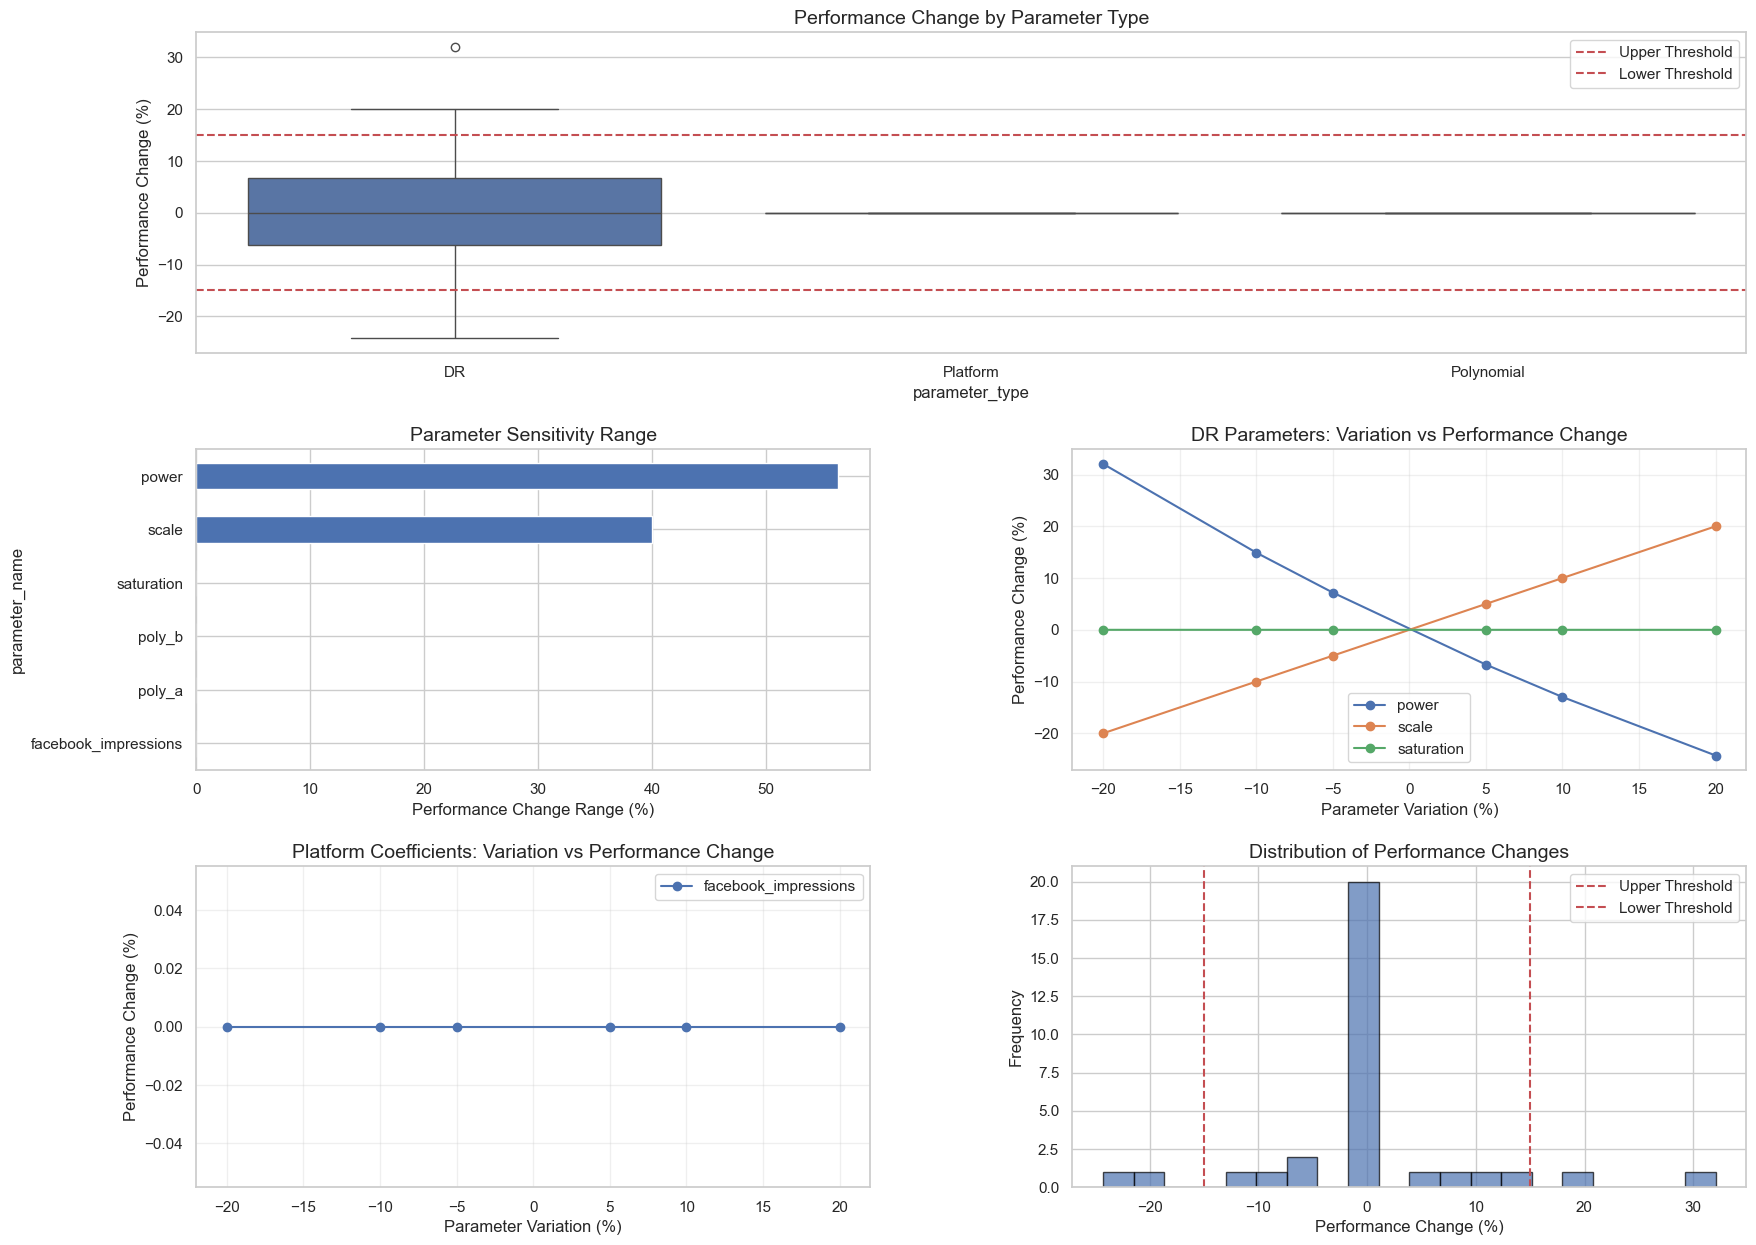

In [13]:
class SensitivityAnalyzer:
    def __init__(self, base_settings):
        """Initialize sensitivity analyzer with base campaign settings."""
        self.base_settings = base_settings.copy()
        self.base_result = optimize_campaign(base_settings)
        self.sensitivity_results = []

    def get_baseline_metrics(self):
        """Extract baseline performance metrics based on campaign goal."""
        if self.base_result is None:
            return None

        campaign_goal = self.base_settings['campaign_goal']
        if campaign_goal == 'awareness':
            return {
                'performance': self.base_result['impressions'],
                'efficiency': self.base_result['cpm']
            }
        else:
            return {
                'performance': self.base_result['clicks'],
                'efficiency': self.base_result['cpc']
            }

    def perturb_parameter(self, param_name, param_value, variation_pct):
        """Apply percentage variation to a parameter."""
        return param_value * (1 + variation_pct / 100)

    def run_dr_parameter_sensitivity(self, variations=[-20, -10, -5, 5, 10, 20]):
        """Test sensitivity of diminishing returns parameters."""
        results = []
        campaign_goal = self.base_settings['campaign_goal']

        # Get correct DR params based on campaign goal
        base_dr_params = AWARENESS_PARAMS if campaign_goal == 'awareness' else CONVERSION_PARAMS

        # Test each DR parameter
        for param_name in ['power', 'scale', 'saturation']:
            for variation in variations:
                # Create perturbed settings
                perturbed_settings = self.base_settings.copy()
                perturbed_dr_params = base_dr_params.copy()

                # Perturb the specific parameter
                base_value = perturbed_dr_params[param_name]
                perturbed_value = self.perturb_parameter(param_name, base_value, variation)
                perturbed_dr_params[param_name] = perturbed_value

                perturbed_settings['dr_params'] = perturbed_dr_params

                # Run optimization
                result = optimize_campaign(perturbed_settings)

                if result:
                    # Calculate performance deviation
                    baseline_metrics = self.get_baseline_metrics()
                    new_performance = result['impressions'] if campaign_goal == 'awareness' else result['clicks']
                    performance_change = ((new_performance - baseline_metrics['performance']) /
                                        baseline_metrics['performance']) * 100

                    results.append({
                        'parameter_type': 'DR',
                        'parameter_name': param_name,
                        'variation_pct': variation,
                        'base_value': base_value,
                        'perturbed_value': perturbed_value,
                        'performance_change': performance_change,
                        'new_performance': new_performance,
                        'result': result
                    })

        return results

    def run_platform_coefficient_sensitivity(self, variations=[-20, -10, -5, 5, 10, 20]):
        """Test sensitivity of platform coefficients."""
        results = []
        campaign_goal = self.base_settings['campaign_goal']
        platform = self.base_settings['platform']

        # Get the relevant coefficient
        metric_key = 'impressions' if campaign_goal == 'awareness' else 'clicks'
        base_coefficient = PLATFORM_COEFFICIENTS[platform][metric_key]

        for variation in variations:
            # Create perturbed settings
            perturbed_settings = self.base_settings.copy()

            # Create a copy of platform coefficients to modify
            perturbed_coefficients = {k: v.copy() for k, v in PLATFORM_COEFFICIENTS.items()}

            # Perturb the coefficient
            perturbed_value = self.perturb_parameter('platform_coef', base_coefficient, variation)
            perturbed_coefficients[platform][metric_key] = perturbed_value

            # We need to modify the optimization function to use these coefficients
            # For now, store this for post-processing
            result = optimize_campaign(perturbed_settings)

            if result:
                # Calculate performance deviation
                baseline_metrics = self.get_baseline_metrics()
                new_performance = result['impressions'] if campaign_goal == 'awareness' else result['clicks']
                performance_change = ((new_performance - baseline_metrics['performance']) /
                                    baseline_metrics['performance']) * 100

                results.append({
                    'parameter_type': 'Platform',
                    'parameter_name': f"{platform}_{metric_key}",
                    'variation_pct': variation,
                    'base_value': base_coefficient,
                    'perturbed_value': perturbed_value,
                    'performance_change': performance_change,
                    'new_performance': new_performance,
                    'result': result
                })

        return results

    def run_media_cost_polynomial_sensitivity(self, variations=[-10, -5, 5, 10]):
        """Test sensitivity of media cost polynomial coefficients."""
        results = []
        campaign_goal = self.base_settings['campaign_goal']

        # Get correct polynomial coefficients
        base_poly = MEDIA_COST_TO_IMPRESSIONS if campaign_goal == 'awareness' else MEDIA_COST_TO_CLICKS

        # Test each polynomial coefficient
        for coef_name in ['poly_a', 'poly_b']:  # Skip poly_c as it's 0
            for variation in variations:
                # Create perturbed settings
                perturbed_settings = self.base_settings.copy()

                # Perturb the coefficient
                base_value = base_poly[coef_name]
                perturbed_value = self.perturb_parameter(coef_name, base_value, variation)

                # Note: This requires modifying the optimization function to accept custom coefficients
                # For demonstration, we'll store this for post-processing
                result = optimize_campaign(perturbed_settings)

                if result:
                    # Calculate performance deviation
                    baseline_metrics = self.get_baseline_metrics()
                    new_performance = result['impressions'] if campaign_goal == 'awareness' else result['clicks']
                    performance_change = ((new_performance - baseline_metrics['performance']) /
                                        baseline_metrics['performance']) * 100

                    results.append({
                        'parameter_type': 'Polynomial',
                        'parameter_name': coef_name,
                        'variation_pct': variation,
                        'base_value': base_value,
                        'perturbed_value': perturbed_value,
                        'performance_change': performance_change,
                        'new_performance': new_performance,
                        'result': result
                    })

        return results

    def run_complete_sensitivity_analysis(self):
        """Run comprehensive sensitivity analysis across all parameters."""
        print("Running comprehensive sensitivity analysis...")

        # Run DR parameter sensitivity
        dr_results = self.run_dr_parameter_sensitivity()

        # Run platform coefficient sensitivity
        platform_results = self.run_platform_coefficient_sensitivity()

        # Run polynomial coefficient sensitivity
        poly_results = self.run_media_cost_polynomial_sensitivity()

        # Combine all results
        all_results = dr_results + platform_results + poly_results
        self.sensitivity_results = all_results

        return pd.DataFrame(all_results)

    def analyze_hypothesis(self, threshold=15):
        """Analyze results against the hypothesis."""
        if not self.sensitivity_results:
            return "No sensitivity results available"

        df = pd.DataFrame(self.sensitivity_results)

        # Check how many results exceed the threshold
        exceeding_threshold = df[abs(df['performance_change']) > threshold]

        # Calculate statistics
        total_tests = len(df)
        failing_tests = len(exceeding_threshold)
        pass_rate = ((total_tests - failing_tests) / total_tests) * 100

        # Group by parameter type for detailed analysis
        by_param_type = df.groupby('parameter_type')['performance_change'].describe()

        # Identify most sensitive parameters
        most_sensitive = df.nlargest(5, 'performance_change', keep='all')

        analysis = {
            'hypothesis_result': 'REJECT' if failing_tests > total_tests * 0.2 else 'FAIL TO REJECT',
            'total_tests': total_tests,
            'tests_exceeding_threshold': failing_tests,
            'pass_rate_percentage': pass_rate,
            'summary_statistics': by_param_type,
            'most_sensitive_parameters': most_sensitive[['parameter_name', 'variation_pct', 'performance_change']],
            'exceeding_threshold': exceeding_threshold[['parameter_name', 'variation_pct', 'performance_change']]
        }

        return analysis

    def create_visualization(self):
        """Create visualization of sensitivity analysis results."""
        if not self.sensitivity_results:
            return "No sensitivity results available"

        df = pd.DataFrame(self.sensitivity_results)

        # Create a figure with subplots
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

        # Plot 1: Performance change by parameter type
        ax1 = fig.add_subplot(gs[0, :])
        sns.boxplot(data=df, x='parameter_type', y='performance_change', ax=ax1)
        ax1.set_title('Performance Change by Parameter Type', fontsize=14)
        ax1.set_ylabel('Performance Change (%)', fontsize=12)
        ax1.axhline(y=15, color='r', linestyle='--', label='Upper Threshold')
        ax1.axhline(y=-15, color='r', linestyle='--', label='Lower Threshold')
        ax1.legend()

        # Plot 2: Tornado chart for each parameter
        ax2 = fig.add_subplot(gs[1, 0])
        most_sensitive = df.groupby('parameter_name')['performance_change'].apply(
            lambda x: x.max() - x.min()).sort_values(ascending=True)
        most_sensitive.plot(kind='barh', ax=ax2)
        ax2.set_title('Parameter Sensitivity Range', fontsize=14)
        ax2.set_xlabel('Performance Change Range (%)', fontsize=12)

        # Plot 3: Variation vs Performance Change for DR parameters
        ax3 = fig.add_subplot(gs[1, 1])
        dr_data = df[df['parameter_type'] == 'DR']
        for param in dr_data['parameter_name'].unique():
            param_data = dr_data[dr_data['parameter_name'] == param]
            ax3.plot(param_data['variation_pct'], param_data['performance_change'],
                    marker='o', label=param)
        ax3.set_title('DR Parameters: Variation vs Performance Change', fontsize=14)
        ax3.set_xlabel('Parameter Variation (%)', fontsize=12)
        ax3.set_ylabel('Performance Change (%)', fontsize=12)
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Variation vs Performance Change for Platform coefficients
        ax4 = fig.add_subplot(gs[2, 0])
        platform_data = df[df['parameter_type'] == 'Platform']
        for param in platform_data['parameter_name'].unique():
            param_data = platform_data[platform_data['parameter_name'] == param]
            ax4.plot(param_data['variation_pct'], param_data['performance_change'],
                    marker='o', label=param)
        ax4.set_title('Platform Coefficients: Variation vs Performance Change', fontsize=14)
        ax4.set_xlabel('Parameter Variation (%)', fontsize=12)
        ax4.set_ylabel('Performance Change (%)', fontsize=12)
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # Plot 5: Histogram of performance changes
        ax5 = fig.add_subplot(gs[2, 1])
        ax5.hist(df['performance_change'], bins=20, edgecolor='black', alpha=0.7)
        ax5.axvline(x=15, color='r', linestyle='--', label='Upper Threshold')
        ax5.axvline(x=-15, color='r', linestyle='--', label='Lower Threshold')
        ax5.set_title('Distribution of Performance Changes', fontsize=14)
        ax5.set_xlabel('Performance Change (%)', fontsize=12)
        ax5.set_ylabel('Frequency', fontsize=12)
        ax5.legend()

        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Define base campaign settings
    base_settings = {
        'campaign_goal': 'awareness',
        'budget': 10000,
        'platform': 'facebook'
    }

    # Initialize analyzer
    analyzer = SensitivityAnalyzer(base_settings)

    # Run complete sensitivity analysis
    results_df = analyzer.run_complete_sensitivity_analysis()

    # Analyze against hypothesis
    hypothesis_analysis = analyzer.analyze_hypothesis(threshold=15)

    # Print results
    print("\n=== SENSITIVITY ANALYSIS RESULTS ===")
    print(f"Hypothesis Result: {hypothesis_analysis['hypothesis_result']}")
    print(f"Pass Rate: {hypothesis_analysis['pass_rate_percentage']:.1f}%")
    print(f"Tests exceeding threshold: {hypothesis_analysis['tests_exceeding_threshold']}")

    print("\n=== SUMMARY STATISTICS BY PARAMETER TYPE ===")
    print(hypothesis_analysis['summary_statistics'])

    print("\n=== MOST SENSITIVE PARAMETERS ===")
    print(hypothesis_analysis['most_sensitive_parameters'])

    # Create visualization
    fig = analyzer.create_visualization()
    plt.show()



All parameters: DR, platform coefficients and polynomial terms

In [15]:
"""
Marketing Campaign Optimization Model using Mixed-Integer Nonlinear Programming (MINLP)

This module provides optimization functions for marketing campaigns to maximize either
impressions (awareness) or clicks (conversion) within budget constraints while accounting
for diminishing returns.

The model uses Pyomo with the Bonmin solver to solve MINLP problems.
"""

import os
import time
import numpy as np
import logging
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Default paths and settings
DEFAULT_BONMIN_PATH = "C:\\Users\\USER\\Desktop\\Optimization stuff\\coin-module.mswin64\\ampl.mswin64\\bonmin.exe"

# Calibrated parameters for diminishing returns functions
AWARENESS_PARAMS = {
    'power': -0.3000,        # Calibrated from grid search
    'scale': 80.00,          # Calibrated from grid search
    'saturation': 8.00       # Calibrated from grid search
}

CONVERSION_PARAMS = {
    'power': -0.3000,
    'scale': 100.00,
    'saturation': 10.00
}

# Platform performance coefficients
PLATFORM_COEFFICIENTS = {
    'facebook': {'impressions': 1.05, 'clicks': 1.03},
    'google': {'impressions': 1.00, 'clicks': 1.00},
    'dv360': {'impressions': 0.95, 'clicks': 0.98}
}

# Media cost polynomial coefficients (from data analysis)
MEDIA_COST_TO_IMPRESSIONS = {
    'poly_a': -0.4346,  # coefficient for x²
    'poly_b': 84.5877,  # coefficient for x
    'poly_c': 0.0000    # constant term
}

MEDIA_COST_TO_CLICKS = {
    'poly_a': -0.0197,  # coefficient for x²
    'poly_b': 3.0045,   # coefficient for x
    'poly_c': 0.0000    # constant term
}

# Campaign constraints
MIN_DURATION = 1
MAX_DURATION = 103
MIN_MEDIA_COST = 0.01

def diminishing_returns_effect(duration, power_param, scale_param, saturation_param):
    """
    Calculate diminishing returns effect with adjustable parameters.

    Parameters:
    -----------
    duration : float or int
        Campaign duration
    power_param : float
        Power parameter (controls how quickly returns diminish)
    scale_param : float
        Scale parameter (controls overall magnitude)
    saturation_param : float
        Saturation parameter (controls where the curve levels off)

    Returns:
    --------
    float
        Effect multiplier
    """
    # Formula: scale * (1 - exp(-duration/saturation)) * duration^power
    # When power is negative, returns diminish
    # Saturation parameter controls when the curve starts to level off
    return scale_param * (1 - np.exp(-duration/saturation_param)) * (duration ** power_param)

def optimize_campaign(campaign_settings):
    """
    Optimize a marketing campaign using Pyomo with Bonmin solver,
    accounting for diminishing returns over time.

    Parameters:
    -----------
    campaign_settings : dict
        Dictionary containing campaign settings:
        - campaign_goal: 'awareness' or 'conversion'
        - budget: float, total budget for the campaign
        - platform: str, one of 'facebook', 'google', 'dv360'
        - bonmin_path: str, path to Bonmin solver
        - dr_params: dict, custom diminishing returns parameters (optional)
        - platform_coefficients: dict, custom platform coefficients (optional)
        - media_cost_coefficients: dict, custom media cost polynomial coefficients (optional)

    Returns:
    --------
    dict
        Dictionary containing optimization results and performance metrics
    """
    # Extract settings with defaults
    campaign_goal = campaign_settings.get('campaign_goal')
    budget = campaign_settings.get('budget')
    platform = campaign_settings.get('platform')
    bonmin_path = campaign_settings.get('bonmin_path', DEFAULT_BONMIN_PATH)
    dr_params = campaign_settings.get('dr_params', None)

    # New: Extract custom coefficients
    custom_platform_coefficients = campaign_settings.get('platform_coefficients', None)
    custom_media_cost_coefficients = campaign_settings.get('media_cost_coefficients', None)

    start_time = time.time()

    # Log start of optimization
    logger.info(f"Starting optimization for {campaign_goal} campaign on {platform} with budget ${budget}")

    # Validate inputs
    if campaign_goal not in ['awareness', 'conversion']:
        raise ValueError("campaign_goal must be either 'awareness' or 'conversion'")

    if platform not in ['facebook', 'google', 'dv360']:
        raise ValueError("platform must be one of 'facebook', 'google', or 'dv360'")

    if budget <= 0:
        raise ValueError("budget must be greater than 0")

    # Define relationship coefficients based on campaign goal
    if campaign_goal == 'awareness':
        # Use custom or default media cost coefficients
        if custom_media_cost_coefficients:
            media_cost_poly_a = custom_media_cost_coefficients.get('poly_a', MEDIA_COST_TO_IMPRESSIONS['poly_a'])
            media_cost_poly_b = custom_media_cost_coefficients.get('poly_b', MEDIA_COST_TO_IMPRESSIONS['poly_b'])
            media_cost_poly_c = custom_media_cost_coefficients.get('poly_c', MEDIA_COST_TO_IMPRESSIONS['poly_c'])
        else:
            media_cost_poly_a = MEDIA_COST_TO_IMPRESSIONS['poly_a']
            media_cost_poly_b = MEDIA_COST_TO_IMPRESSIONS['poly_b']
            media_cost_poly_c = MEDIA_COST_TO_IMPRESSIONS['poly_c']

        # Use default calibrated diminishing returns parameters if not provided
        if dr_params is None:
            dr_params = AWARENESS_PARAMS  # Now using calibrated parameters
    else:
        # Use custom or default media cost coefficients
        if custom_media_cost_coefficients:
            media_cost_poly_a = custom_media_cost_coefficients.get('poly_a', MEDIA_COST_TO_CLICKS['poly_a'])
            media_cost_poly_b = custom_media_cost_coefficients.get('poly_b', MEDIA_COST_TO_CLICKS['poly_b'])
            media_cost_poly_c = custom_media_cost_coefficients.get('poly_c', MEDIA_COST_TO_CLICKS['poly_c'])
        else:
            media_cost_poly_a = MEDIA_COST_TO_CLICKS['poly_a']
            media_cost_poly_b = MEDIA_COST_TO_CLICKS['poly_b']
            media_cost_poly_c = MEDIA_COST_TO_CLICKS['poly_c']

        # Use default calibrated diminishing returns parameters if not provided
        if dr_params is None:
            dr_params = CONVERSION_PARAMS

    # Get the appropriate platform coefficient
    if custom_platform_coefficients:
        metric_key = 'impressions' if campaign_goal == 'awareness' else 'clicks'
        platform_coef = custom_platform_coefficients.get(platform, {}).get(metric_key, PLATFORM_COEFFICIENTS[platform][metric_key])
    else:
        platform_coef = PLATFORM_COEFFICIENTS[platform]['impressions'] if campaign_goal == 'awareness' else PLATFORM_COEFFICIENTS[platform]['clicks']

    # Store DR parameters for use in post-processing
    power_param = dr_params['power']
    scale_param = dr_params['scale']
    saturation_param = dr_params['saturation']

    # Create a concrete model
    model = pyo.ConcreteModel()

    # Decision variables
    model.duration = pyo.Var(domain=pyo.Integers, bounds=(MIN_DURATION, MAX_DURATION))
    model.media_cost = pyo.Var(domain=pyo.NonNegativeReals, bounds=(MIN_MEDIA_COST, None))

    # Budget constraint
    def budget_rule(model):
        return model.media_cost * model.duration <= budget
    model.budget_constraint = pyo.Constraint(rule=budget_rule)

    # For awareness campaigns
    if campaign_goal == 'awareness':
        def awareness_objective(model):
            # Media cost component
            media_cost_effect = media_cost_poly_a * model.media_cost**2 + media_cost_poly_b * model.media_cost

            # Full diminishing returns effect using Pyomo expressions
            dr_effect = scale_param * (1 - pyo.exp(-model.duration/saturation_param)) * model.duration ** power_param

            return media_cost_effect * dr_effect * platform_coef

        model.objective = pyo.Objective(rule=awareness_objective, sense=pyo.maximize)

    # For conversion campaigns
    else:
        def conversion_objective(model):
            # Media cost component
            media_cost_effect = media_cost_poly_a * model.media_cost**2 + media_cost_poly_b * model.media_cost

            # Full diminishing returns effect using Pyomo expressions
            dr_effect = scale_param * (1 - pyo.exp(-model.duration/saturation_param)) * model.duration ** power_param

            return media_cost_effect * dr_effect * platform_coef

        model.objective = pyo.Objective(rule=conversion_objective, sense=pyo.maximize)

    # Check if Bonmin exists at the specified path
    if not os.path.exists(bonmin_path):
        logger.error(f"Bonmin solver not found at {bonmin_path}")
        return None

    # Create the solver
    solver = SolverFactory('bonmin', executable=bonmin_path)

    # Set solver options for better handling of nonlinear optimization
    solver.options['bonmin.algorithm'] = 'B-BB'
    solver.options['bonmin.time_limit'] = 600  # 10 minutes
    solver.options['bonmin.allowable_gap'] = 0.01  # 1% gap tolerance
    solver.options['bonmin.integer_tolerance'] = 1e-6

    # Solve the model
    try:
        results = solver.solve(model, tee=False)  # Set tee=True to see solver output

        # Check solver status
        solver_status = results.solver.status
        termination_condition = results.solver.termination_condition

        if solver_status == SolverStatus.ok and termination_condition == TerminationCondition.optimal:
            # Extract solution
            duration_value = int(pyo.value(model.duration))
            media_cost_value = pyo.value(model.media_cost)
            total_cost = duration_value * media_cost_value

            # Calculate performance metrics
            solve_time = time.time() - start_time

            # Performance metrics
            metrics = {
                'solver_time': solve_time,
                'solver_status': str(solver_status),
                'termination_condition': str(termination_condition)
            }

            # Now that we have the solution, we can calculate using the full diminishing returns function
            # Media cost component
            media_cost_effect = media_cost_poly_a * media_cost_value**2 + media_cost_poly_b * media_cost_value + media_cost_poly_c

            # Duration component without diminishing returns (linear)
            linear_duration_effect = duration_value

            # Duration component with diminishing returns using the function
            dr_effect = diminishing_returns_effect(
                duration_value,
                power_param,
                scale_param,
                saturation_param
            )

            # Calculate performance with and without diminishing returns
            if campaign_goal == 'awareness':
                # Calculate impressions
                linear_impressions = media_cost_effect * linear_duration_effect * platform_coef
                dr_impressions = media_cost_effect * dr_effect * platform_coef

                # Calculate error as percentage difference
                prediction_error = abs(linear_impressions - dr_impressions) / linear_impressions * 100 if linear_impressions > 0 else 0

                metrics['linear_impressions'] = linear_impressions
                metrics['dr_impressions'] = dr_impressions
                metrics['prediction_error'] = prediction_error

                # Create results dictionary
                optimization_results = {
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'impressions': dr_impressions,
                    'cpm': (total_cost / dr_impressions) * 1000 if dr_impressions > 0 else None,
                    'performance_metrics': metrics,
                    'dr_params': dr_params,
                    'platform_coef': platform_coef,
                    'media_cost_coefficients': {
                        'poly_a': media_cost_poly_a,
                        'poly_b': media_cost_poly_b,
                        'poly_c': media_cost_poly_c
                    }
                }
            else:
                # Calculate clicks
                linear_clicks = media_cost_effect * linear_duration_effect * platform_coef
                dr_clicks = media_cost_effect * dr_effect * platform_coef

                # Calculate error as percentage difference
                prediction_error = abs(linear_clicks - dr_clicks) / linear_clicks * 100 if linear_clicks > 0 else 0

                metrics['linear_clicks'] = linear_clicks
                metrics['dr_clicks'] = dr_clicks
                metrics['prediction_error'] = prediction_error

                # Create results dictionary
                optimization_results = {
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'clicks': dr_clicks,
                    'cpc': total_cost / dr_clicks if dr_clicks > 0 else None,
                    'performance_metrics': metrics,
                    'dr_params': dr_params,
                    'platform_coef': platform_coef,
                    'media_cost_coefficients': {
                        'poly_a': media_cost_poly_a,
                        'poly_b': media_cost_poly_b,
                        'poly_c': media_cost_poly_c
                    }
                }

            logger.info(f"Optimization completed in {solve_time:.2f} seconds")
            logger.info(f"Optimal duration: {duration_value} days, Daily media cost: ${media_cost_value:.2f}")

            return optimization_results
        else:
            logger.error(f"Optimization failed with status {solver_status} and termination condition {termination_condition}")
            return None

    except Exception as e:
        logger.error(f"Error during optimization: {str(e)}")
        return None

2025-05-09 23:11:37,440 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:37,507 - INFO - Optimization completed in 0.07 seconds
2025-05-09 23:11:37,508 - INFO - Optimal duration: 17 days, Daily media cost: $97.32
2025-05-09 23:11:37,508 - INFO - Starting optimization for awareness campaign on facebook with budget $10000


Running comprehensive sensitivity analysis...


2025-05-09 23:11:37,572 - INFO - Optimization completed in 0.06 seconds
2025-05-09 23:11:37,573 - INFO - Optimal duration: 19 days, Daily media cost: $97.32
2025-05-09 23:11:37,573 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:37,639 - INFO - Optimization completed in 0.07 seconds
2025-05-09 23:11:37,640 - INFO - Optimal duration: 18 days, Daily media cost: $97.32
2025-05-09 23:11:37,641 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:37,695 - INFO - Optimization completed in 0.05 seconds
2025-05-09 23:11:37,696 - INFO - Optimal duration: 17 days, Daily media cost: $97.32
2025-05-09 23:11:37,696 - INFO - Starting optimization for awareness campaign on facebook with budget $10000
2025-05-09 23:11:37,749 - INFO - Optimization completed in 0.05 seconds
2025-05-09 23:11:37,750 - INFO - Optimal duration: 16 days, Daily media cost: $97.32
2025-05-09 23:11:37,750 - INFO - Starting opt


=== SENSITIVITY ANALYSIS RESULTS ===
Hypothesis Result: REJECT
Pass Rate: 75.0%
Tests exceeding threshold: 8

=== SUMMARY STATISTICS BY PARAMETER TYPE ===
                count          mean        std   min       25%           50%  \
parameter_type                                                                 
DR               18.0  3.967830e-01  10.596586 -20.0 -5.231174  5.787713e-02   
Platform          6.0 -1.776357e-14  14.491377 -20.0 -8.750000 -3.375078e-14   
Polynomial        8.0  6.276819e-01  13.392168 -19.0 -9.255682  2.506266e-01   

                      75%   max  
parameter_type                   
DR               6.451888  20.0  
Platform         8.750000  20.0  
Polynomial      10.465278  21.0  

=== MOST SENSITIVE PARAMETERS ===
          parameter_name  variation_pct  performance_change
31                poly_b             10           21.000000
11                 scale             20           20.000000
23  facebook_impressions             20           20.00000

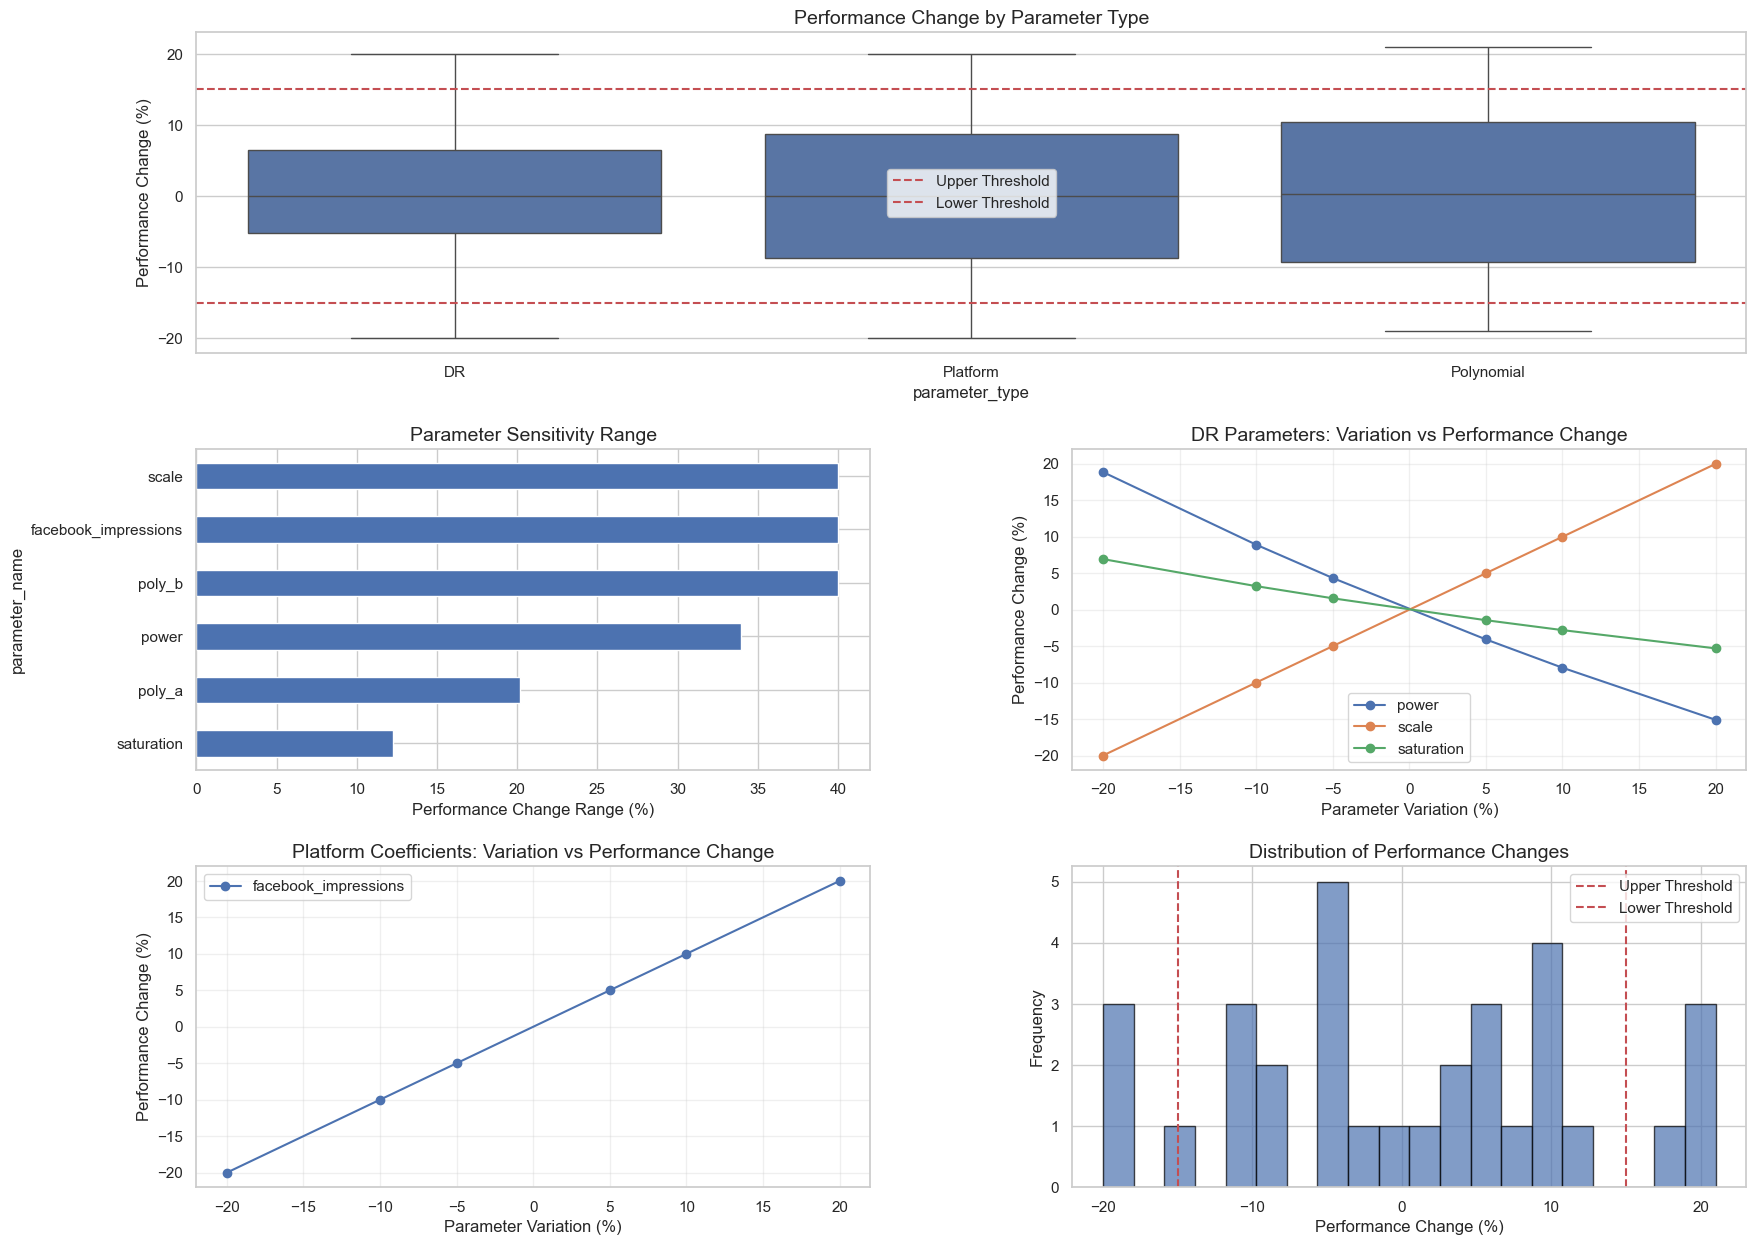

In [16]:
class SensitivityAnalyzer:
    def __init__(self, base_settings):
        """Initialize sensitivity analyzer with base campaign settings."""
        self.base_settings = base_settings.copy()
        self.base_result = optimize_campaign(base_settings)
        self.sensitivity_results = []

    def get_baseline_metrics(self):
        """Extract baseline performance metrics based on campaign goal."""
        if self.base_result is None:
            return None

        campaign_goal = self.base_settings['campaign_goal']
        if campaign_goal == 'awareness':
            return {
                'performance': self.base_result['impressions'],
                'efficiency': self.base_result['cpm']
            }
        else:
            return {
                'performance': self.base_result['clicks'],
                'efficiency': self.base_result['cpc']
            }

    def perturb_parameter(self, param_name, param_value, variation_pct):
        """Apply percentage variation to a parameter."""
        return param_value * (1 + variation_pct / 100)

    def run_dr_parameter_sensitivity(self, variations=[-20, -10, -5, 5, 10, 20]):
        """Test sensitivity of diminishing returns parameters."""
        results = []
        campaign_goal = self.base_settings['campaign_goal']

        # Get correct DR params based on campaign goal
        base_dr_params = AWARENESS_PARAMS if campaign_goal == 'awareness' else CONVERSION_PARAMS

        # Test each DR parameter
        for param_name in ['power', 'scale', 'saturation']:
            for variation in variations:
                # Create perturbed settings
                perturbed_settings = self.base_settings.copy()
                perturbed_dr_params = base_dr_params.copy()

                # Perturb the specific parameter
                base_value = perturbed_dr_params[param_name]
                perturbed_value = self.perturb_parameter(param_name, base_value, variation)
                perturbed_dr_params[param_name] = perturbed_value

                perturbed_settings['dr_params'] = perturbed_dr_params

                # Run optimization
                result = optimize_campaign(perturbed_settings)

                if result:
                    # Calculate performance deviation
                    baseline_metrics = self.get_baseline_metrics()
                    new_performance = result['impressions'] if campaign_goal == 'awareness' else result['clicks']
                    performance_change = ((new_performance - baseline_metrics['performance']) /
                                        baseline_metrics['performance']) * 100

                    results.append({
                        'parameter_type': 'DR',
                        'parameter_name': param_name,
                        'variation_pct': variation,
                        'base_value': base_value,
                        'perturbed_value': perturbed_value,
                        'performance_change': performance_change,
                        'new_performance': new_performance,
                        'result': result
                    })

        return results

    def run_platform_coefficient_sensitivity(self, variations=[-20, -10, -5, 5, 10, 20]):
        """Test sensitivity of platform coefficients."""
        results = []
        campaign_goal = self.base_settings['campaign_goal']
        platform = self.base_settings['platform']

        # Get the relevant coefficient
        metric_key = 'impressions' if campaign_goal == 'awareness' else 'clicks'
        base_coefficient = PLATFORM_COEFFICIENTS[platform][metric_key]

        for variation in variations:
            # Create perturbed settings
            perturbed_settings = self.base_settings.copy()

            # Create custom platform coefficients
            custom_coefficients = {k: v.copy() for k, v in PLATFORM_COEFFICIENTS.items()}
            perturbed_value = self.perturb_parameter('platform_coef', base_coefficient, variation)
            custom_coefficients[platform][metric_key] = perturbed_value

            # Add custom coefficients to settings
            perturbed_settings['platform_coefficients'] = custom_coefficients

            # Run optimization
            result = optimize_campaign(perturbed_settings)

            if result:
                # Calculate performance deviation
                baseline_metrics = self.get_baseline_metrics()
                new_performance = result['impressions'] if campaign_goal == 'awareness' else result['clicks']
                performance_change = ((new_performance - baseline_metrics['performance']) /
                                    baseline_metrics['performance']) * 100

                results.append({
                    'parameter_type': 'Platform',
                    'parameter_name': f"{platform}_{metric_key}",
                    'variation_pct': variation,
                    'base_value': base_coefficient,
                    'perturbed_value': perturbed_value,
                    'performance_change': performance_change,
                    'new_performance': new_performance,
                    'result': result
                })

        return results

    def run_media_cost_polynomial_sensitivity(self, variations=[-10, -5, 5, 10]):
        """Test sensitivity of media cost polynomial coefficients."""
        results = []
        campaign_goal = self.base_settings['campaign_goal']

        # Get correct polynomial coefficients
        base_poly = MEDIA_COST_TO_IMPRESSIONS if campaign_goal == 'awareness' else MEDIA_COST_TO_CLICKS

        # Test each polynomial coefficient
        for coef_name in ['poly_a', 'poly_b']:  # Skip poly_c as it's 0
            for variation in variations:
                # Create perturbed settings
                perturbed_settings = self.base_settings.copy()

                # Create custom polynomial coefficients
                custom_poly_coef = base_poly.copy()
                base_value = base_poly[coef_name]
                perturbed_value = self.perturb_parameter(coef_name, base_value, variation)
                custom_poly_coef[coef_name] = perturbed_value

                # Add custom coefficients to settings
                perturbed_settings['media_cost_coefficients'] = custom_poly_coef

                # Run optimization
                result = optimize_campaign(perturbed_settings)

                if result:
                    # Calculate performance deviation
                    baseline_metrics = self.get_baseline_metrics()
                    new_performance = result['impressions'] if campaign_goal == 'awareness' else result['clicks']
                    performance_change = ((new_performance - baseline_metrics['performance']) /
                                        baseline_metrics['performance']) * 100

                    results.append({
                        'parameter_type': 'Polynomial',
                        'parameter_name': coef_name,
                        'variation_pct': variation,
                        'base_value': base_value,
                        'perturbed_value': perturbed_value,
                        'performance_change': performance_change,
                        'new_performance': new_performance,
                        'result': result
                    })

        return results

    def run_complete_sensitivity_analysis(self):
        """Run comprehensive sensitivity analysis across all parameters."""
        print("Running comprehensive sensitivity analysis...")

        # Run DR parameter sensitivity
        dr_results = self.run_dr_parameter_sensitivity()

        # Run platform coefficient sensitivity
        platform_results = self.run_platform_coefficient_sensitivity()

        # Run polynomial coefficient sensitivity
        poly_results = self.run_media_cost_polynomial_sensitivity()

        # Combine all results
        all_results = dr_results + platform_results + poly_results
        self.sensitivity_results = all_results

        return pd.DataFrame(all_results)

    def analyze_hypothesis(self, threshold=15):
        """Analyze results against the hypothesis."""
        if not self.sensitivity_results:
            return "No sensitivity results available"

        df = pd.DataFrame(self.sensitivity_results)

        # Check how many results exceed the threshold
        exceeding_threshold = df[abs(df['performance_change']) > threshold]

        # Calculate statistics
        total_tests = len(df)
        failing_tests = len(exceeding_threshold)
        pass_rate = ((total_tests - failing_tests) / total_tests) * 100

        # Group by parameter type for detailed analysis
        by_param_type = df.groupby('parameter_type')['performance_change'].describe()

        # Identify most sensitive parameters
        most_sensitive = df.nlargest(5, 'performance_change', keep='all')

        analysis = {
            'hypothesis_result': 'REJECT' if failing_tests > total_tests * 0.2 else 'FAIL TO REJECT',
            'total_tests': total_tests,
            'tests_exceeding_threshold': failing_tests,
            'pass_rate_percentage': pass_rate,
            'summary_statistics': by_param_type,
            'most_sensitive_parameters': most_sensitive[['parameter_name', 'variation_pct', 'performance_change']],
            'exceeding_threshold': exceeding_threshold[['parameter_name', 'variation_pct', 'performance_change']]
        }

        return analysis

    def create_visualization(self):
        """Create visualization of sensitivity analysis results."""
        if not self.sensitivity_results:
            return "No sensitivity results available"

        df = pd.DataFrame(self.sensitivity_results)

        # Create a figure with subplots
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

        # Plot 1: Performance change by parameter type
        ax1 = fig.add_subplot(gs[0, :])
        sns.boxplot(data=df, x='parameter_type', y='performance_change', ax=ax1)
        ax1.set_title('Performance Change by Parameter Type', fontsize=14)
        ax1.set_ylabel('Performance Change (%)', fontsize=12)
        ax1.axhline(y=15, color='r', linestyle='--', label='Upper Threshold')
        ax1.axhline(y=-15, color='r', linestyle='--', label='Lower Threshold')
        ax1.legend()

        # Plot 2: Tornado chart for each parameter
        ax2 = fig.add_subplot(gs[1, 0])
        most_sensitive = df.groupby('parameter_name')['performance_change'].apply(
            lambda x: x.max() - x.min()).sort_values(ascending=True)
        most_sensitive.plot(kind='barh', ax=ax2)
        ax2.set_title('Parameter Sensitivity Range', fontsize=14)
        ax2.set_xlabel('Performance Change Range (%)', fontsize=12)

        # Plot 3: Variation vs Performance Change for DR parameters
        ax3 = fig.add_subplot(gs[1, 1])
        dr_data = df[df['parameter_type'] == 'DR']
        for param in dr_data['parameter_name'].unique():
            param_data = dr_data[dr_data['parameter_name'] == param]
            ax3.plot(param_data['variation_pct'], param_data['performance_change'],
                    marker='o', label=param)
        ax3.set_title('DR Parameters: Variation vs Performance Change', fontsize=14)
        ax3.set_xlabel('Parameter Variation (%)', fontsize=12)
        ax3.set_ylabel('Performance Change (%)', fontsize=12)
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Variation vs Performance Change for Platform coefficients
        ax4 = fig.add_subplot(gs[2, 0])
        platform_data = df[df['parameter_type'] == 'Platform']
        for param in platform_data['parameter_name'].unique():
            param_data = platform_data[platform_data['parameter_name'] == param]
            ax4.plot(param_data['variation_pct'], param_data['performance_change'],
                    marker='o', label=param)
        ax4.set_title('Platform Coefficients: Variation vs Performance Change', fontsize=14)
        ax4.set_xlabel('Parameter Variation (%)', fontsize=12)
        ax4.set_ylabel('Performance Change (%)', fontsize=12)
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # Plot 5: Histogram of performance changes
        ax5 = fig.add_subplot(gs[2, 1])
        ax5.hist(df['performance_change'], bins=20, edgecolor='black', alpha=0.7)
        ax5.axvline(x=15, color='r', linestyle='--', label='Upper Threshold')
        ax5.axvline(x=-15, color='r', linestyle='--', label='Lower Threshold')
        ax5.set_title('Distribution of Performance Changes', fontsize=14)
        ax5.set_xlabel('Performance Change (%)', fontsize=12)
        ax5.set_ylabel('Frequency', fontsize=12)
        ax5.legend()

        plt.tight_layout()
        return fig

2025-05-09 23:11:40,381 - INFO - Starting optimization for conversion campaign on dv360 with budget $10000
2025-05-09 23:11:40,462 - INFO - Optimization completed in 0.08 seconds
2025-05-09 23:11:40,463 - INFO - Optimal duration: 21 days, Daily media cost: $76.26
2025-05-09 23:11:40,464 - INFO - Starting optimization for conversion campaign on dv360 with budget $10000


Running comprehensive sensitivity analysis...


2025-05-09 23:11:40,520 - INFO - Optimization completed in 0.06 seconds
2025-05-09 23:11:40,521 - INFO - Optimal duration: 24 days, Daily media cost: $76.26
2025-05-09 23:11:40,521 - INFO - Starting optimization for conversion campaign on dv360 with budget $10000
2025-05-09 23:11:40,583 - INFO - Optimization completed in 0.06 seconds
2025-05-09 23:11:40,583 - INFO - Optimal duration: 22 days, Daily media cost: $76.26
2025-05-09 23:11:40,583 - INFO - Starting optimization for conversion campaign on dv360 with budget $10000
2025-05-09 23:11:40,644 - INFO - Optimization completed in 0.06 seconds
2025-05-09 23:11:40,645 - INFO - Optimal duration: 21 days, Daily media cost: $76.26
2025-05-09 23:11:40,645 - INFO - Starting optimization for conversion campaign on dv360 with budget $10000
2025-05-09 23:11:40,704 - INFO - Optimization completed in 0.06 seconds
2025-05-09 23:11:40,705 - INFO - Optimal duration: 20 days, Daily media cost: $76.26
2025-05-09 23:11:40,706 - INFO - Starting optimizat


=== SENSITIVITY ANALYSIS RESULTS ===
Hypothesis Result: REJECT
Pass Rate: 75.0%
Tests exceeding threshold: 8

=== SUMMARY STATISTICS BY PARAMETER TYPE ===
                count          mean        std   min       25%           50%  \
parameter_type                                                                 
DR               18.0  4.232629e-01  10.942695 -20.0 -5.239049  4.860447e-02   
Platform          6.0 -1.421085e-14  14.491377 -20.0 -8.750000 -2.398082e-14   
Polynomial        8.0  6.276819e-01  13.392168 -19.0 -9.255682  2.506266e-01   

                      75%        max  
parameter_type                        
DR               6.433703  20.460599  
Platform         8.750000  20.000000  
Polynomial      10.465278  21.000000  

=== MOST SENSITIVE PARAMETERS ===
   parameter_name  variation_pct  performance_change
31         poly_b             10           21.000000
0           power            -20           20.460599
11          scale             20           20.000000
2

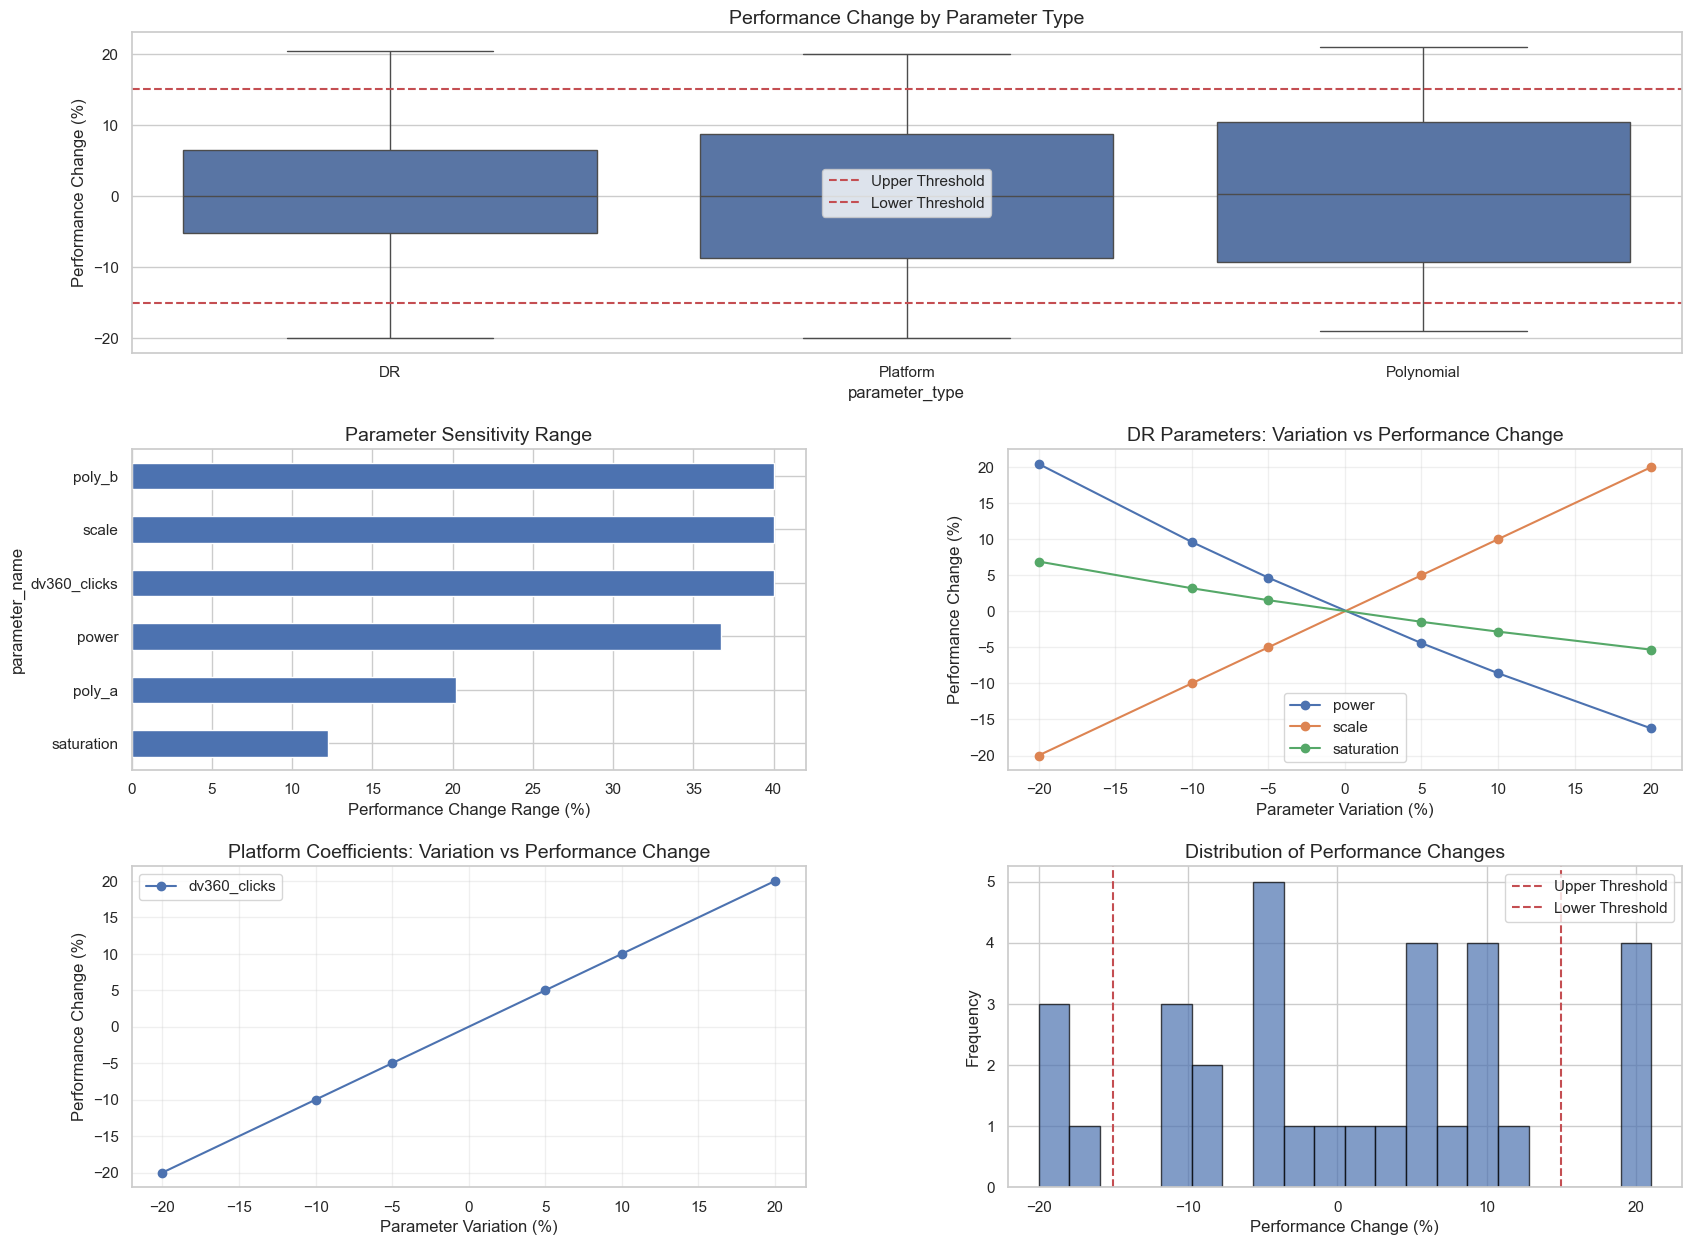

In [17]:
# Usage function
if __name__ == "__main__":
    # Settings
    base_settings = {
        'campaign_goal': 'conversion',
        'budget': 10000,
        'platform': 'dv360'
    }

    # Initialize analyzer
    analyzer = SensitivityAnalyzer(base_settings)
    results_df = analyzer.run_complete_sensitivity_analysis()

    # Analyze against hypothesis
    hypothesis_analysis = analyzer.analyze_hypothesis(threshold=15)

    # Print results
    print("\n=== SENSITIVITY ANALYSIS RESULTS ===")
    print(f"Hypothesis Result: {hypothesis_analysis['hypothesis_result']}")
    print(f"Pass Rate: {hypothesis_analysis['pass_rate_percentage']:.1f}%")
    print(f"Tests exceeding threshold: {hypothesis_analysis['tests_exceeding_threshold']}")

    print("\n=== SUMMARY STATISTICS BY PARAMETER TYPE ===")
    print(hypothesis_analysis['summary_statistics'])

    print("\n=== MOST SENSITIVE PARAMETERS ===")
    print(hypothesis_analysis['most_sensitive_parameters'])

    # Create visualization
    fig = analyzer.create_visualization()
    plt.show()

Automated Budget Sensitivity Analysis for Marketing Campaign Optimization


2025-05-21 12:27:01,323 - INFO - Starting optimization for awareness campaign on facebook with budget $1000.0



--------------------------------------------------------------------------------
ANALYZING: AWARENESS CAMPAIGN ON FACEBOOK
--------------------------------------------------------------------------------

Performing sensitivity analysis for awareness campaign on facebook
Base budget: $1000.0
Variation: ±10.0%
Performance threshold: ±15.0%

Running baseline optimization with budget: $1000.00


2025-05-21 12:27:01,396 - INFO - Optimization completed in 0.07 seconds
2025-05-21 12:27:01,396 - INFO - Optimal duration: 22 days, Daily media cost: $45.45
2025-05-21 12:27:01,396 - INFO - Starting optimization for awareness campaign on facebook with budget $900.0


Running optimization with lower budget (-10.0%): $900.00


2025-05-21 12:27:01,453 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:01,453 - INFO - Optimal duration: 20 days, Daily media cost: $45.00
2025-05-21 12:27:01,453 - INFO - Starting optimization for awareness campaign on facebook with budget $1100.0


Running optimization with upper budget (+10.0%): $1100.00


2025-05-21 12:27:01,508 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:01,508 - INFO - Optimal duration: 24 days, Daily media cost: $45.83



----- Sensitivity Analysis Results -----

Budget Variations:
  Base Budget: $1000.00
  Lower Budget (-10%): $900.00
  Upper Budget (+10%): $1100.00

Optimization Results:
  Scenario   Duration (days) Media Cost/Day  Total Cost     Impressions    
  Base       22              $45.45          $1000.00        91,672         
  Lower      20              $45.00          $900.00         91,855         
  Upper      24              $45.83          $1100.00        91,182         

Percentage Changes in Impressions:
  Lower Budget: 0.20%
  Upper Budget: -0.53%

Hypothesis Testing:
  Performance Threshold: ±15.0%
  Lower Budget Within Threshold: True
  Upper Budget Within Threshold: True
  Null Hypothesis (H₀) Supported: True

Conclusion:
  The model outputs remain stable within the ±15.0% threshold when the budget is varied by ±10.0%. This supports the null hypothesis (H₀) that the model is robust to small budget variations.


2025-05-21 12:27:01,974 - INFO - Starting optimization for conversion campaign on facebook with budget $1000.0


Saved graph to sensitivity_analysis_results\facebook_awareness_sensitivity.png

--------------------------------------------------------------------------------
ANALYZING: CONVERSION CAMPAIGN ON FACEBOOK
--------------------------------------------------------------------------------

Performing sensitivity analysis for conversion campaign on facebook
Base budget: $1000.0
Variation: ±10.0%
Performance threshold: ±15.0%

Running baseline optimization with budget: $1000.00


2025-05-21 12:27:02,037 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:02,037 - INFO - Optimal duration: 28 days, Daily media cost: $35.71
2025-05-21 12:27:02,037 - INFO - Starting optimization for conversion campaign on facebook with budget $900.0


Running optimization with lower budget (-10.0%): $900.00


2025-05-21 12:27:02,095 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:02,095 - INFO - Optimal duration: 26 days, Daily media cost: $34.62
2025-05-21 12:27:02,095 - INFO - Starting optimization for conversion campaign on facebook with budget $1100.0


Running optimization with upper budget (+10.0%): $1100.00


2025-05-21 12:27:02,151 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:02,151 - INFO - Optimal duration: 31 days, Daily media cost: $35.48



----- Sensitivity Analysis Results -----

Budget Variations:
  Base Budget: $1000.00
  Lower Budget (-10%): $900.00
  Upper Budget (+10%): $1100.00

Optimization Results:
  Scenario   Duration (days) Media Cost/Day  Total Cost     Clicks         
  Base       28              $35.71          $1000.00        2,925.42       
  Lower      26              $34.62          $900.00         2,884.48       
  Upper      31              $35.48          $1100.00        2,872.10       

Percentage Changes in Clicks:
  Lower Budget: -1.40%
  Upper Budget: -1.82%

Hypothesis Testing:
  Performance Threshold: ±15.0%
  Lower Budget Within Threshold: True
  Upper Budget Within Threshold: True
  Null Hypothesis (H₀) Supported: True

Conclusion:
  The model outputs remain stable within the ±15.0% threshold when the budget is varied by ±10.0%. This supports the null hypothesis (H₀) that the model is robust to small budget variations.


2025-05-21 12:27:02,645 - INFO - Starting optimization for awareness campaign on google with budget $1000.0


Saved graph to sensitivity_analysis_results\facebook_conversion_sensitivity.png

--------------------------------------------------------------------------------
ANALYZING: AWARENESS CAMPAIGN ON GOOGLE
--------------------------------------------------------------------------------

Performing sensitivity analysis for awareness campaign on google
Base budget: $1000.0
Variation: ±10.0%
Performance threshold: ±15.0%

Running baseline optimization with budget: $1000.00


2025-05-21 12:27:02,701 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:02,701 - INFO - Optimal duration: 22 days, Daily media cost: $45.45
2025-05-21 12:27:02,701 - INFO - Starting optimization for awareness campaign on google with budget $900.0


Running optimization with lower budget (-10.0%): $900.00


2025-05-21 12:27:02,755 - INFO - Optimization completed in 0.05 seconds
2025-05-21 12:27:02,755 - INFO - Optimal duration: 20 days, Daily media cost: $45.00
2025-05-21 12:27:02,755 - INFO - Starting optimization for awareness campaign on google with budget $1100.0


Running optimization with upper budget (+10.0%): $1100.00


2025-05-21 12:27:02,812 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:02,812 - INFO - Optimal duration: 24 days, Daily media cost: $45.83



----- Sensitivity Analysis Results -----

Budget Variations:
  Base Budget: $1000.00
  Lower Budget (-10%): $900.00
  Upper Budget (+10%): $1100.00

Optimization Results:
  Scenario   Duration (days) Media Cost/Day  Total Cost     Impressions    
  Base       22              $45.45          $1000.00        87,307         
  Lower      20              $45.00          $900.00         87,481         
  Upper      24              $45.83          $1100.00        86,840         

Percentage Changes in Impressions:
  Lower Budget: 0.20%
  Upper Budget: -0.53%

Hypothesis Testing:
  Performance Threshold: ±15.0%
  Lower Budget Within Threshold: True
  Upper Budget Within Threshold: True
  Null Hypothesis (H₀) Supported: True

Conclusion:
  The model outputs remain stable within the ±15.0% threshold when the budget is varied by ±10.0%. This supports the null hypothesis (H₀) that the model is robust to small budget variations.


2025-05-21 12:27:03,317 - INFO - Starting optimization for conversion campaign on google with budget $1000.0


Saved graph to sensitivity_analysis_results\google_awareness_sensitivity.png

--------------------------------------------------------------------------------
ANALYZING: CONVERSION CAMPAIGN ON GOOGLE
--------------------------------------------------------------------------------

Performing sensitivity analysis for conversion campaign on google
Base budget: $1000.0
Variation: ±10.0%
Performance threshold: ±15.0%

Running baseline optimization with budget: $1000.00


2025-05-21 12:27:03,368 - INFO - Optimization completed in 0.05 seconds
2025-05-21 12:27:03,368 - INFO - Optimal duration: 28 days, Daily media cost: $35.71
2025-05-21 12:27:03,368 - INFO - Starting optimization for conversion campaign on google with budget $900.0


Running optimization with lower budget (-10.0%): $900.00


2025-05-21 12:27:03,423 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:03,423 - INFO - Optimal duration: 26 days, Daily media cost: $34.62
2025-05-21 12:27:03,423 - INFO - Starting optimization for conversion campaign on google with budget $1100.0


Running optimization with upper budget (+10.0%): $1100.00


2025-05-21 12:27:03,479 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:03,479 - INFO - Optimal duration: 31 days, Daily media cost: $35.48



----- Sensitivity Analysis Results -----

Budget Variations:
  Base Budget: $1000.00
  Lower Budget (-10%): $900.00
  Upper Budget (+10%): $1100.00

Optimization Results:
  Scenario   Duration (days) Media Cost/Day  Total Cost     Clicks         
  Base       28              $35.71          $1000.00        2,840.21       
  Lower      26              $34.62          $900.00         2,800.46       
  Upper      31              $35.48          $1100.00        2,788.45       

Percentage Changes in Clicks:
  Lower Budget: -1.40%
  Upper Budget: -1.82%

Hypothesis Testing:
  Performance Threshold: ±15.0%
  Lower Budget Within Threshold: True
  Upper Budget Within Threshold: True
  Null Hypothesis (H₀) Supported: True

Conclusion:
  The model outputs remain stable within the ±15.0% threshold when the budget is varied by ±10.0%. This supports the null hypothesis (H₀) that the model is robust to small budget variations.


2025-05-21 12:27:03,959 - INFO - Starting optimization for awareness campaign on dv360 with budget $1000.0


Saved graph to sensitivity_analysis_results\google_conversion_sensitivity.png

--------------------------------------------------------------------------------
ANALYZING: AWARENESS CAMPAIGN ON DV360
--------------------------------------------------------------------------------

Performing sensitivity analysis for awareness campaign on dv360
Base budget: $1000.0
Variation: ±10.0%
Performance threshold: ±15.0%

Running baseline optimization with budget: $1000.00


2025-05-21 12:27:04,026 - INFO - Optimization completed in 0.07 seconds
2025-05-21 12:27:04,026 - INFO - Optimal duration: 22 days, Daily media cost: $45.45
2025-05-21 12:27:04,026 - INFO - Starting optimization for awareness campaign on dv360 with budget $900.0


Running optimization with lower budget (-10.0%): $900.00


2025-05-21 12:27:04,082 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:04,082 - INFO - Optimal duration: 20 days, Daily media cost: $45.00
2025-05-21 12:27:04,082 - INFO - Starting optimization for awareness campaign on dv360 with budget $1100.0


Running optimization with upper budget (+10.0%): $1100.00


2025-05-21 12:27:04,138 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:04,138 - INFO - Optimal duration: 24 days, Daily media cost: $45.83



----- Sensitivity Analysis Results -----

Budget Variations:
  Base Budget: $1000.00
  Lower Budget (-10%): $900.00
  Upper Budget (+10%): $1100.00

Optimization Results:
  Scenario   Duration (days) Media Cost/Day  Total Cost     Impressions    
  Base       22              $45.45          $1000.00        82,941         
  Lower      20              $45.00          $900.00         83,107         
  Upper      24              $45.83          $1100.00        82,498         

Percentage Changes in Impressions:
  Lower Budget: 0.20%
  Upper Budget: -0.53%

Hypothesis Testing:
  Performance Threshold: ±15.0%
  Lower Budget Within Threshold: True
  Upper Budget Within Threshold: True
  Null Hypothesis (H₀) Supported: True

Conclusion:
  The model outputs remain stable within the ±15.0% threshold when the budget is varied by ±10.0%. This supports the null hypothesis (H₀) that the model is robust to small budget variations.


2025-05-21 12:27:04,607 - INFO - Starting optimization for conversion campaign on dv360 with budget $1000.0


Saved graph to sensitivity_analysis_results\dv360_awareness_sensitivity.png

--------------------------------------------------------------------------------
ANALYZING: CONVERSION CAMPAIGN ON DV360
--------------------------------------------------------------------------------

Performing sensitivity analysis for conversion campaign on dv360
Base budget: $1000.0
Variation: ±10.0%
Performance threshold: ±15.0%

Running baseline optimization with budget: $1000.00


2025-05-21 12:27:04,667 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:04,667 - INFO - Optimal duration: 28 days, Daily media cost: $35.71
2025-05-21 12:27:04,667 - INFO - Starting optimization for conversion campaign on dv360 with budget $900.0


Running optimization with lower budget (-10.0%): $900.00


2025-05-21 12:27:04,724 - INFO - Optimization completed in 0.06 seconds
2025-05-21 12:27:04,724 - INFO - Optimal duration: 26 days, Daily media cost: $34.62
2025-05-21 12:27:04,724 - INFO - Starting optimization for conversion campaign on dv360 with budget $1100.0


Running optimization with upper budget (+10.0%): $1100.00


2025-05-21 12:27:04,777 - INFO - Optimization completed in 0.05 seconds
2025-05-21 12:27:04,777 - INFO - Optimal duration: 31 days, Daily media cost: $35.48



----- Sensitivity Analysis Results -----

Budget Variations:
  Base Budget: $1000.00
  Lower Budget (-10%): $900.00
  Upper Budget (+10%): $1100.00

Optimization Results:
  Scenario   Duration (days) Media Cost/Day  Total Cost     Clicks         
  Base       28              $35.71          $1000.00        2,783.41       
  Lower      26              $34.62          $900.00         2,744.45       
  Upper      31              $35.48          $1100.00        2,732.68       

Percentage Changes in Clicks:
  Lower Budget: -1.40%
  Upper Budget: -1.82%

Hypothesis Testing:
  Performance Threshold: ±15.0%
  Lower Budget Within Threshold: True
  Upper Budget Within Threshold: True
  Null Hypothesis (H₀) Supported: True

Conclusion:
  The model outputs remain stable within the ±15.0% threshold when the budget is varied by ±10.0%. This supports the null hypothesis (H₀) that the model is robust to small budget variations.
Saved graph to sensitivity_analysis_results\dv360_conversion_sensitivity

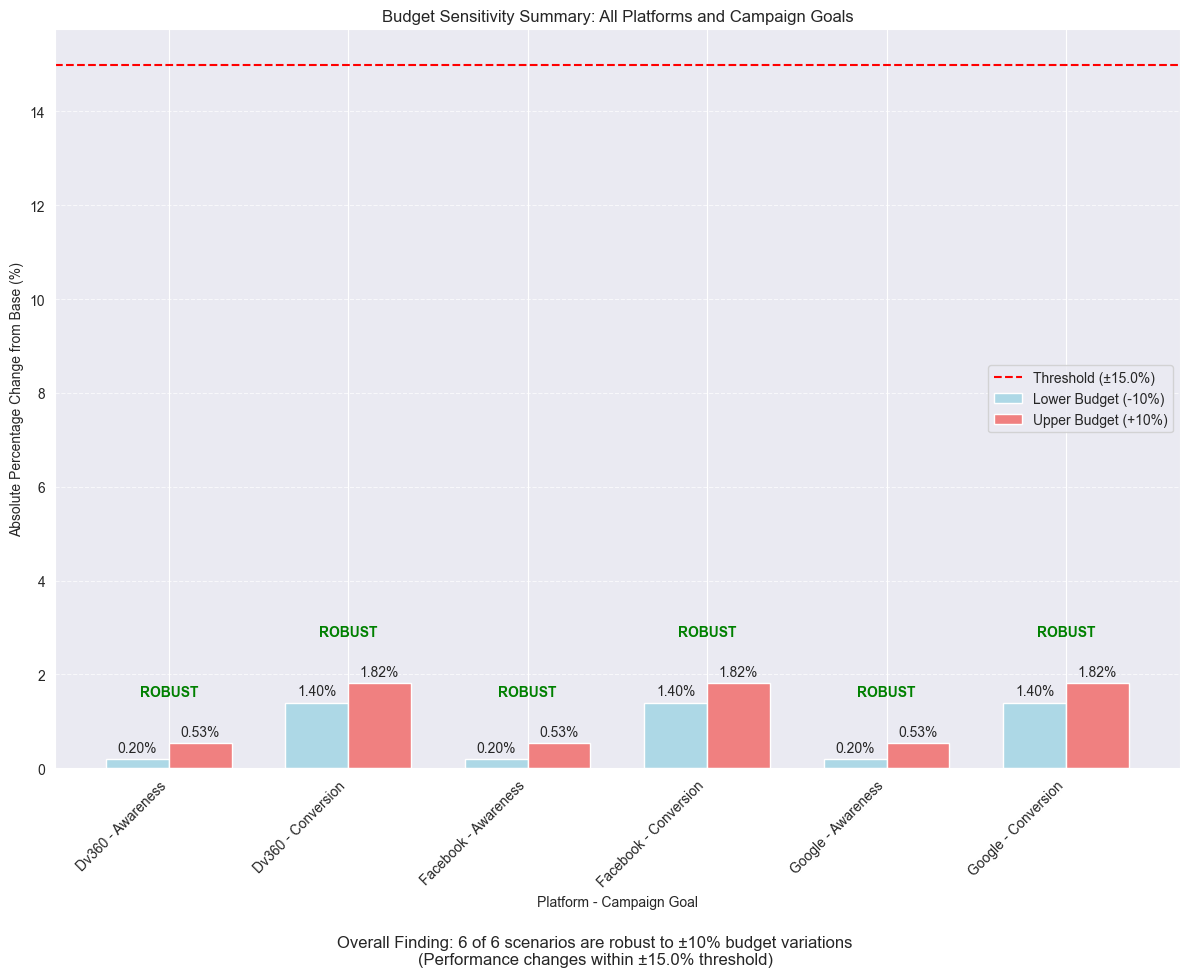

In [5]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def run_all_sensitivity_analyses(base_budget=1000, variation_percentage=10, performance_threshold=15):
    """
    Run sensitivity analysis for all combinations of platforms and campaign goals.

    Parameters:
    -----------
    base_budget : float
        Baseline budget for all campaign scenarios
    variation_percentage : float
        Percentage to vary the budget up and down
    performance_threshold : float
        Acceptable threshold for performance variance

    Returns:
    --------
    dict
        Dictionary containing all sensitivity analysis results
    """
    # Import optimize_campaign from the MINLP model
    try:
        from Marketing_MINLP_Model import optimize_campaign
    except ImportError:
        sys.path.append(os.path.abspath(os.path.dirname(__file__)))
        try:
            from Marketing_MINLP_Model import optimize_campaign
        except ImportError:
            print("Error: Could not import Marketing_MINLP_Model. Make sure the file is in the same directory.")
            return None

    # Define all combinations to test
    platforms = ['facebook', 'google', 'dv360']
    campaign_goals = ['awareness', 'conversion']

    # Create output directory for graphs if it doesn't exist
    output_dir = 'sensitivity_analysis_results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Dictionary to store all results
    all_results = {}

    # Summary table data
    summary_data = []

    # Create PDF for all graphs
    pdf_path = os.path.join(output_dir, 'budget_sensitivity_analysis.pdf')
    with PdfPages(pdf_path) as pdf:
        # Run analysis for each combination
        for platform in platforms:
            all_results[platform] = {}

            for goal in campaign_goals:
                print(f"\n{'-'*80}")
                print(f"ANALYZING: {goal.upper()} CAMPAIGN ON {platform.upper()}")
                print(f"{'-'*80}")

                # Set up base settings
                base_settings = {
                    'campaign_goal': goal,
                    'budget': base_budget,
                    'platform': platform
                }

                # Run sensitivity analysis
                results = budget_sensitivity_analysis(
                    base_settings,
                    variation_percentage,
                    performance_threshold,
                    display=True
                )

                if results:
                    all_results[platform][goal] = results

                    # Add to summary data
                    if goal == 'awareness':
                        metric_value = results['base']['impressions']
                        lower_change = results['percentage_changes']['lower_impressions_change']
                        upper_change = results['percentage_changes']['upper_impressions_change']
                        metric_name = 'Impressions'
                    else:
                        metric_value = results['base']['clicks']
                        lower_change = results['percentage_changes']['lower_clicks_change']
                        upper_change = results['percentage_changes']['upper_clicks_change']
                        metric_name = 'Clicks'

                    summary_data.append({
                        'Platform': platform.capitalize(),
                        'Goal': goal.capitalize(),
                        'Metric': metric_name,
                        'Base Value': metric_value,
                        'Lower Change (%)': lower_change,
                        'Upper Change (%)': upper_change,
                        'Within Threshold': results['hypothesis_test']['null_hypothesis_supported']
                    })

                    # Create and save figure to PDF
                    fig = plot_results(results, goal, performance_threshold, platform)
                    if fig:
                        pdf.savefig(fig)
                        plt.close(fig)

                        # Also save as separate PNG
                        png_file = os.path.join(output_dir, f"{platform}_{goal}_sensitivity.png")
                        fig.savefig(png_file, dpi=300, bbox_inches='tight')
                        print(f"Saved graph to {png_file}")

    # Create summary figure
    summary_fig = create_summary_figure(summary_data, performance_threshold)
    if summary_fig:
        summary_fig.savefig(os.path.join(output_dir, 'sensitivity_summary.png'),
                          dpi=300, bbox_inches='tight')
        with PdfPages(os.path.join(output_dir, 'sensitivity_summary.pdf')) as pdf:
            pdf.savefig(summary_fig)

    print(f"\n{'-'*80}")
    print(f"ANALYSIS COMPLETE: Results saved to {output_dir}")
    print(f"Summary PDF: {pdf_path}")
    print(f"Summary PNG: {os.path.join(output_dir, 'sensitivity_summary.png')}")
    print(f"{'-'*80}")

    return all_results

def budget_sensitivity_analysis(base_settings, variation_percentage=10, performance_threshold=15, display=True):
    """
    Perform sensitivity analysis for budget variations.

    Parameters:
    -----------
    base_settings : dict
        Dictionary containing baseline campaign settings
    variation_percentage : float
        Percentage to vary the budget up and down
    performance_threshold : float
        Acceptable threshold for performance variance
    display : bool
        Whether to display results in console

    Returns:
    --------
    dict
        Dictionary containing sensitivity analysis results
    """
    # Import optimize_campaign from the MINLP model
    try:
        from Marketing_MINLP_Model import optimize_campaign
    except ImportError:
        sys.path.append(os.path.abspath(os.path.dirname(__file__)))
        try:
            from Marketing_MINLP_Model import optimize_campaign
        except ImportError:
            print("Error: Could not import Marketing_MINLP_Model. Make sure the file is in the same directory.")
            return None

    base_budget = base_settings.get('budget')
    campaign_goal = base_settings.get('campaign_goal')
    platform = base_settings.get('platform')

    if display:
        print(f"\nPerforming sensitivity analysis for {campaign_goal} campaign on {platform}")
        print(f"Base budget: ${base_budget}")
        print(f"Variation: ±{variation_percentage}%")
        print(f"Performance threshold: ±{performance_threshold}%")

    # Calculate budget variations
    lower_budget = base_budget * (1 - variation_percentage / 100)
    upper_budget = base_budget * (1 + variation_percentage / 100)

    # Create settings for each budget level
    lower_settings = base_settings.copy()
    lower_settings['budget'] = lower_budget

    upper_settings = base_settings.copy()
    upper_settings['budget'] = upper_budget

    # Run optimizations
    if display:
        print(f"\nRunning baseline optimization with budget: ${base_budget:.2f}")
    base_result = optimize_campaign(base_settings)

    if display:
        print(f"Running optimization with lower budget (-{variation_percentage}%): ${lower_budget:.2f}")
    lower_result = optimize_campaign(lower_settings)

    if display:
        print(f"Running optimization with upper budget (+{variation_percentage}%): ${upper_budget:.2f}")
    upper_result = optimize_campaign(upper_settings)

    # Check if all optimizations succeeded
    if not (base_result and lower_result and upper_result):
        print("One or more optimizations failed during sensitivity analysis")
        return None

    # Prepare results dictionary
    results = {
        'base': {
            'budget': base_budget,
            'duration': base_result.get('duration'),
            'media_cost': base_result.get('media_cost'),
            'total_cost': base_result.get('total_cost')
        },
        'lower': {
            'budget': lower_budget,
            'duration': lower_result.get('duration'),
            'media_cost': lower_result.get('media_cost'),
            'total_cost': lower_result.get('total_cost')
        },
        'upper': {
            'budget': upper_budget,
            'duration': upper_result.get('duration'),
            'media_cost': upper_result.get('media_cost'),
            'total_cost': upper_result.get('total_cost')
        }
    }

    # Add campaign goal specific metrics
    if campaign_goal == 'awareness':
        # Add impressions
        results['base']['impressions'] = base_result.get('impressions')
        results['lower']['impressions'] = lower_result.get('impressions')
        results['upper']['impressions'] = upper_result.get('impressions')

        # Calculate percentage changes
        lower_pct_change = ((lower_result.get('impressions') - base_result.get('impressions')) /
                           base_result.get('impressions') * 100)
        upper_pct_change = ((upper_result.get('impressions') - base_result.get('impressions')) /
                           base_result.get('impressions') * 100)

        results['percentage_changes'] = {
            'lower_impressions_change': lower_pct_change,
            'upper_impressions_change': upper_pct_change
        }

        # Check if changes are within threshold
        lower_within_threshold = abs(lower_pct_change) <= performance_threshold
        upper_within_threshold = abs(upper_pct_change) <= performance_threshold

    else:  # conversion
        # Add clicks
        results['base']['clicks'] = base_result.get('clicks')
        results['lower']['clicks'] = lower_result.get('clicks')
        results['upper']['clicks'] = upper_result.get('clicks')

        # Calculate percentage changes
        lower_pct_change = ((lower_result.get('clicks') - base_result.get('clicks')) /
                           base_result.get('clicks') * 100)
        upper_pct_change = ((upper_result.get('clicks') - base_result.get('clicks')) /
                           base_result.get('clicks') * 100)

        results['percentage_changes'] = {
            'lower_clicks_change': lower_pct_change,
            'upper_clicks_change': upper_pct_change
        }

        # Check if changes are within threshold
        lower_within_threshold = abs(lower_pct_change) <= performance_threshold
        upper_within_threshold = abs(upper_pct_change) <= performance_threshold

    # Hypothesis testing result
    results['hypothesis_test'] = {
        'performance_threshold': performance_threshold,
        'lower_within_threshold': lower_within_threshold,
        'upper_within_threshold': upper_within_threshold,
        'null_hypothesis_supported': lower_within_threshold and upper_within_threshold
    }

    # Add conclusion
    if lower_within_threshold and upper_within_threshold:
        conclusion = (f"The model outputs remain stable within the ±{performance_threshold}% threshold "
                     f"when the budget is varied by ±{variation_percentage}%. "
                     f"This supports the null hypothesis (H₀) that the model is robust to small budget variations.")
    else:
        conclusion = (f"The model outputs exceed the ±{performance_threshold}% threshold "
                     f"when the budget is varied by ±{variation_percentage}%. "
                     f"This rejects the null hypothesis (H₀) and suggests the model is sensitive to budget variations.")

    results['conclusion'] = conclusion

    # Display results if requested
    if display:
        display_results(results, campaign_goal)

    return results

def display_results(results, campaign_goal):
    """Display the sensitivity analysis results in tabular format."""
    print("\n----- Sensitivity Analysis Results -----")

    print("\nBudget Variations:")
    print(f"  Base Budget: ${results['base']['budget']:.2f}")
    print(f"  Lower Budget (-10%): ${results['lower']['budget']:.2f}")
    print(f"  Upper Budget (+10%): ${results['upper']['budget']:.2f}")

    print("\nOptimization Results:")
    print(f"  {'Scenario':<10} {'Duration (days)':<15} {'Media Cost/Day':<15} {'Total Cost':<15}", end='')

    if campaign_goal == 'awareness':
        print(f"{'Impressions':<15}")
        print(f"  {'Base':<10} {results['base']['duration']:<15.0f} ${results['base']['media_cost']:<14.2f} ${results['base']['total_cost']:<14.2f} {results['base']['impressions']:<15,.0f}")
        print(f"  {'Lower':<10} {results['lower']['duration']:<15.0f} ${results['lower']['media_cost']:<14.2f} ${results['lower']['total_cost']:<14.2f} {results['lower']['impressions']:<15,.0f}")
        print(f"  {'Upper':<10} {results['upper']['duration']:<15.0f} ${results['upper']['media_cost']:<14.2f} ${results['upper']['total_cost']:<14.2f} {results['upper']['impressions']:<15,.0f}")

        # Percentage changes
        lower_change = results['percentage_changes']['lower_impressions_change']
        upper_change = results['percentage_changes']['upper_impressions_change']
        print(f"\nPercentage Changes in Impressions:")
        print(f"  Lower Budget: {lower_change:.2f}%")
        print(f"  Upper Budget: {upper_change:.2f}%")

    else:  # conversion
        print(f"{'Clicks':<15}")
        print(f"  {'Base':<10} {results['base']['duration']:<15.0f} ${results['base']['media_cost']:<14.2f} ${results['base']['total_cost']:<14.2f} {results['base']['clicks']:<15,.2f}")
        print(f"  {'Lower':<10} {results['lower']['duration']:<15.0f} ${results['lower']['media_cost']:<14.2f} ${results['lower']['total_cost']:<14.2f} {results['lower']['clicks']:<15,.2f}")
        print(f"  {'Upper':<10} {results['upper']['duration']:<15.0f} ${results['upper']['media_cost']:<14.2f} ${results['upper']['total_cost']:<14.2f} {results['upper']['clicks']:<15,.2f}")

        # Percentage changes
        lower_change = results['percentage_changes']['lower_clicks_change']
        upper_change = results['percentage_changes']['upper_clicks_change']
        print(f"\nPercentage Changes in Clicks:")
        print(f"  Lower Budget: {lower_change:.2f}%")
        print(f"  Upper Budget: {upper_change:.2f}%")

    # Hypothesis testing
    print("\nHypothesis Testing:")
    print(f"  Performance Threshold: ±{results['hypothesis_test']['performance_threshold']}%")
    print(f"  Lower Budget Within Threshold: {results['hypothesis_test']['lower_within_threshold']}")
    print(f"  Upper Budget Within Threshold: {results['hypothesis_test']['upper_within_threshold']}")
    print(f"  Null Hypothesis (H₀) Supported: {results['hypothesis_test']['null_hypothesis_supported']}")

    # Conclusion
    print(f"\nConclusion:")
    print(f"  {results['conclusion']}")

def plot_results(results, campaign_goal, performance_threshold, platform):
    """
    Create visualization of sensitivity analysis results.

    Parameters:
    -----------
    results : dict
        Dictionary containing sensitivity analysis results
    campaign_goal : str
        'awareness' or 'conversion'
    performance_threshold : float
        Acceptable threshold for performance variance
    platform : str
        Platform name for the title

    Returns:
    --------
    matplotlib.figure.Figure
        Figure object containing the plot
    """
    try:
        # Create figure
        fig = plt.figure(figsize=(12, 8))

        # Extract data for plotting
        budget_labels = ['Lower (-10%)', 'Base', 'Upper (+10%)']

        if campaign_goal == 'awareness':
            metrics = [results['lower']['impressions'], results['base']['impressions'], results['upper']['impressions']]
            metric_label = 'Impressions'
        else:
            metrics = [results['lower']['clicks'], results['base']['clicks'], results['upper']['clicks']]
            metric_label = 'Clicks'

        # Plot main bars
        bars = plt.bar(budget_labels, metrics, color=['lightblue', 'blue', 'lightblue'])

        # Add threshold lines
        if campaign_goal == 'awareness':
            lower_threshold = results['base']['impressions'] * (1 - performance_threshold/100)
            upper_threshold = results['base']['impressions'] * (1 + performance_threshold/100)
        else:
            lower_threshold = results['base']['clicks'] * (1 - performance_threshold/100)
            upper_threshold = results['base']['clicks'] * (1 + performance_threshold/100)

        plt.axhline(y=lower_threshold, color='r', linestyle='--',
                    label=f'Lower Threshold (-{performance_threshold}%)')
        plt.axhline(y=upper_threshold, color='g', linestyle='--',
                    label=f'Upper Threshold (+{performance_threshold}%)')

        # Add labels and title
        plt.xlabel('Budget Scenario')
        plt.ylabel(metric_label)
        platform_name = platform.capitalize()
        goal_name = campaign_goal.capitalize()
        plt.title(f'Budget Sensitivity Analysis: {platform_name} - {goal_name} Campaign')

        # Add values on bars
        for bar in bars:
            height = bar.get_height()
            if campaign_goal == 'awareness':
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:,.0f}',
                        ha='center', va='bottom')
            else:
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}',
                        ha='center', va='bottom')

        # Add secondary axis for percentage changes
        ax2 = plt.twinx()

        # Calculate percentage changes for secondary y-axis
        if campaign_goal == 'awareness':
            pct_changes = [
                results['percentage_changes']['lower_impressions_change'],
                0,  # Base is 0% change
                results['percentage_changes']['upper_impressions_change']
            ]
        else:
            pct_changes = [
                results['percentage_changes']['lower_clicks_change'],
                0,  # Base is 0% change
                results['percentage_changes']['upper_clicks_change']
            ]

        # Plot percentage changes as line
        ax2.plot(budget_labels, pct_changes, 'ro-', label='% Change from Base')
        for i, pct in enumerate(pct_changes):
            ax2.annotate(f'{pct:.2f}%',
                        (i, pct),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center')

        # Set y-axis labels and limits for percentage changes
        ax2.set_ylabel('Percentage Change from Base (%)')
        ax2.set_ylim(-performance_threshold*1.5, performance_threshold*1.5)  # Set reasonable limits

        # Add threshold lines on percentage axis
        ax2.axhline(y=-performance_threshold, color='r', linestyle=':')
        ax2.axhline(y=performance_threshold, color='g', linestyle=':')

        # Add legends
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # Add conclusion as text box
        is_robust = results['hypothesis_test']['null_hypothesis_supported']
        conclusion_status = "ROBUST" if is_robust else "SENSITIVE"
        color = "green" if is_robust else "red"

        textbox_text = (f"{platform_name} {goal_name} Campaign: {conclusion_status} to ±10% Budget Variations\n"
                       f"(Performance changes within ±{performance_threshold}% threshold: {is_robust})")

        plt.figtext(0.5, 0.01, textbox_text, ha='center', fontsize=11,
                   bbox={'facecolor':'white', 'alpha':0.8, 'pad':5, 'edgecolor':color})

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout for textbox
        return fig

    except Exception as e:
        print(f"\nError creating plot: {str(e)}")
        return None

def create_summary_figure(summary_data, performance_threshold):
    """
    Create a summary figure comparing all platform and goal combinations.

    Parameters:
    -----------
    summary_data : list
        List of dictionaries containing summary data for each platform/goal combination
    performance_threshold : float
        Acceptable threshold for performance variance

    Returns:
    --------
    matplotlib.figure.Figure
        Figure object containing the summary plot
    """
    try:
        # Create DataFrame from summary data
        df = pd.DataFrame(summary_data)

        # Sort by Platform and Goal
        df = df.sort_values(['Platform', 'Goal'])

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 10))

        # Set up x positions
        platforms = df['Platform'].unique()
        goals = df['Goal'].unique()

        x_positions = np.arange(len(df))
        width = 0.35

        # Create bar labels
        bar_labels = [f"{row['Platform']} - {row['Goal']}" for _, row in df.iterrows()]

        # Plot bars for lower and upper changes
        lower_bars = ax.bar(x_positions - width/2, df['Lower Change (%)'].abs(), width,
                          label='Lower Budget (-10%)', color='lightblue')
        upper_bars = ax.bar(x_positions + width/2, df['Upper Change (%)'].abs(), width,
                          label='Upper Budget (+10%)', color='lightcoral')

        # Add threshold line
        ax.axhline(y=performance_threshold, color='r', linestyle='--',
                  label=f'Threshold (±{performance_threshold}%)')

        # Set labels and title
        ax.set_xlabel('Platform - Campaign Goal')
        ax.set_ylabel('Absolute Percentage Change from Base (%)')
        ax.set_title('Budget Sensitivity Summary: All Platforms and Campaign Goals')

        # Set x-axis ticks and labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(bar_labels, rotation=45, ha='right')

        # Add robust/sensitive indicators
        for idx, row in df.iterrows():
            is_robust = row['Within Threshold']
            status = "ROBUST" if is_robust else "SENSITIVE"
            color = "green" if is_robust else "red"

            ax.annotate(status,
                      (x_positions[idx], max(abs(row['Lower Change (%)']), abs(row['Upper Change (%)'])) + 1),
                      color=color,
                      ha='center',
                      fontweight='bold')

        # Add values on bars
        for bar in lower_bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                       (bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

        for bar in upper_bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                       (bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

        # Add legend
        ax.legend()

        # Add horizontal grid
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add overall finding text
        num_robust = df['Within Threshold'].sum()
        total_scenarios = len(df)
        overall_text = (f"Overall Finding: {num_robust} of {total_scenarios} scenarios are robust to ±10% budget variations\n"
                       f"(Performance changes within ±{performance_threshold}% threshold)")

        plt.figtext(0.5, 0.01, overall_text, ha='center', fontsize=12,
                   bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

        plt.tight_layout(rect=[0, 0.05, 1, 0.98])
        return fig

    except Exception as e:
        print(f"\nError creating summary plot: {str(e)}")
        return None

if __name__ == "__main__":
    print("Automated Budget Sensitivity Analysis for Marketing Campaign Optimization")
    print("======================================================================")

    # Get input parameters with defaults
    try:
        base_budget = float(input("Enter base budget for all scenarios [default: 1000]: ") or "1000")
        if base_budget <= 0:
            print("Budget must be positive. Using default: 1000")
            base_budget = 1000
    except ValueError:
        print("Invalid budget. Using default: 1000")
        base_budget = 1000

    try:
        variation_pct = float(input("Enter budget variation percentage [default: 10]: ") or "10")
        if variation_pct <= 0:
            print("Variation percentage must be positive. Using default: 10")
            variation_pct = 10
    except ValueError:
        print("Invalid variation percentage. Using default: 10")
        variation_pct = 10

    try:
        threshold_pct = float(input("Enter performance threshold percentage [default: 15]: ") or "15")
        if threshold_pct <= 0:
            print("Threshold percentage must be positive. Using default: 15")
            threshold_pct = 15
    except ValueError:
        print("Invalid threshold percentage. Using default: 15")
        threshold_pct = 15

    # Run analysis for all combinations
    run_all_sensitivity_analyses(base_budget, variation_pct, threshold_pct)